In [14]:
!pip install transformers underthesea torch numpy pandas json


ERROR: Could not find a version that satisfies the requirement json (from versions: none)
ERROR: No matching distribution found for json

[notice] A new release of pip available: 22.3 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [15]:
from transformers import AutoTokenizer, AutoModel
import torch
import json 
import numpy as np
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)
model = AutoModel.from_pretrained("vinai/phobert-base")

In [16]:
with open(r"D:\NCKH\estimate_question_difficulty\Tokenizer\questions.json", "r", encoding="utf-8") as f:
    data = json.load(f)

In [17]:
sentences = []
for item in data:
    subject = f"Môn: {item['subject']}"
    question = f"Câu hỏi: {item['question']}"
    options = " | ".join([f"{k}: {v}" for k, v in item["options"].items()])
    answer = f"Đáp án: {item['answer']}"
    text = f"{subject} {question} {options} {answer}"
    sentences.append(text)

print("Số câu hỏi cần embedding:", len(sentences))

Số câu hỏi cần embedding: 149


Khúc này để xử lý mấy ngoại lệ bị lỗi với lấy embedding từng dòng

In [18]:
def get_embedding(text):
    if not text.strip():
        return np.zeros(768)
    try:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
        with torch.no_grad():
            outputs = model(**inputs)
        return outputs.last_hidden_state[:, 0, :].squeeze().numpy()
    except Exception as e:
        print("Lỗi với câu:", text, "\nChi tiết:", e)
        return np.zeros(768)

In [19]:
import numpy as np

embeddings = []
for sent in sentences:
    emb = get_embedding(sent)
    embeddings.append(emb)

embeddings = np.array(embeddings)
print("Shape embeddings:", embeddings.shape)  # (số_câu, 768)



Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Shape embeddings: (149, 768)


Muốn save sang npy thì chạy block này


In [20]:
np.save(r"D:\NCKH\estimate_question_difficulty\Tokenizer\embeddings.npy", embeddings)
print("Đã lưu embeddings vào embeddings.npy")


Đã lưu embeddings vào embeddings.npy


Còn muốn save sang csv để check thì như này

In [21]:
import pandas as pd

df = pd.DataFrame(embeddings)
df.insert(0, "sentence", sentences)  # thêm cột câu gốc

df.to_csv(r"D:\NCKH\estimate_question_difficulty\Tokenizer\embeddings.csv", index=False, encoding="utf-8")
print("Đã lưu embeddings vào embeddings.csv")

Đã lưu embeddings vào embeddings.csv



[notice] A new release of pip available: 22.3 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


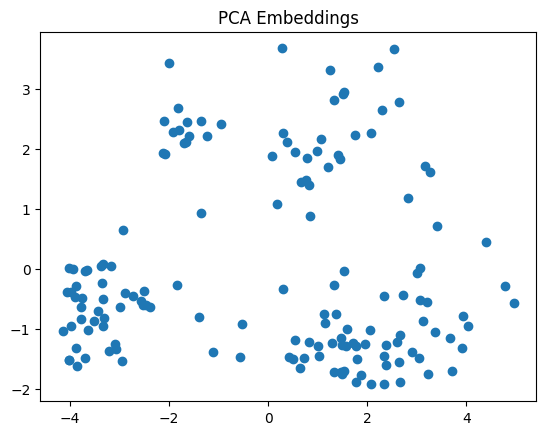

In [22]:
!pip install matplotlib
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
reduced = pca.fit_transform(embeddings)

plt.scatter(reduced[:,0], reduced[:,1])
plt.title("PCA Embeddings")
plt.show()